In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

import glob
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2
import math

DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

/home/izza/install/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Image Recognition

In [7]:
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
        label_lookup_path = 'model/imagenet_2012_challenge_label_map_proto.pbtxt'
    if not uid_lookup_path: 
        uid_lookup_path = 'model/imagenet_synset_to_human_label_map.txt'
    
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]


def create_graph():
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile('model/classify_image_graph_def.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

def run_inference_on_image_file(images, num_top_predictions=3):
    """Runs inference on an image.

    Args:
    image: Image file name.

    Returns:
    Nothing
    """
    for image in images :
        if not tf.gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)
    
    images_data = {}
    for image in images :
        image_data = tf.gfile.FastGFile(image, 'rb').read()
        images_data[image] = image_data
        
    result = {}
    # Creates graph from saved GraphDef.
    create_graph()

    with tf.Session() as sess:
        for filename in images_data :
            image_data = images_data[filename]            
            # Some useful tensors:
            # 'softmax:0': A tensor containing the normalized prediction across
            #   1000 labels.
            # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
            #   float description of the image.
            # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
            #   encoding of the image.
            # Runs the softmax tensor by feeding the image_data as input to the graph.
            softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
            predictions = sess.run(softmax_tensor,
                                   {'DecodeJpeg/contents:0': image_data})
            predictions = np.squeeze(predictions)

            # Creates node ID --> English string lookup.
            node_lookup = NodeLookup()
            file_writer = tf.summary.FileWriter('/home/izza/Project/DataExtraction', sess.graph)

            prediction_summary = "";
            top_k = predictions.argsort()[-num_top_predictions:][::-1]
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                prediction_summary += '%s (score = %.5f)' % (human_string, score)
            result[filename] = prediction_summary
    return result

def run_inference_on_image(images_data, num_top_predictions=3):
    result = {}
    # Creates graph from saved GraphDef.
    create_graph()

    with tf.Session() as sess:
        for filename in images_data :
            image_data = images_data[filename]            
            softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
            x = tf.constant(image_data)
            predictions = sess.run(softmax_tensor,
                                   {'DecodeJpeg:0': image_data})
            predictions = np.squeeze(predictions)

            # Creates node ID --> English string lookup.
            node_lookup = NodeLookup()
#             file_writer = tf.summary.FileWriter('/home/izza/Project/DataExtraction', sess.graph)

            prediction_summary = "";
            top_k = predictions.argsort()[-num_top_predictions:][::-1]
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                prediction_summary += '%s (score = %.5f)' % (human_string, score)
            result[filename] = prediction_summary
    return result

def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = "model"
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def recognize_object_from_file(image_files):
  maybe_download_and_extract()
  return run_inference_on_image_file(image_files)

def recognize_object(images):
    maybe_download_and_extract()
    return run_inference_on_image(images)

In [5]:
recognize_object_from_file(["images/fish.png"])

{'images/fish.png': 'goldfish, Carassius auratus (score = 0.90761)rock beauty, Holocanthus tricolor (score = 0.00086)proboscis monkey, Nasalis larvatus (score = 0.00085)'}

# Video Slicing

In [13]:
def slice_video(videoFile = 'videos/big_buck_bunny.mp4', frameDiffTime=1, save=False, video_name="unknown") : 
    cap = cv2.VideoCapture(videoFile)
    frameRate = frameDiffTime * cap.get(5) #frame rate
    frames = {}
    
    count = 0
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        
        if (frameId % math.floor(frameRate) == 0):
            filename = "videos/frames/" +  video_name + "_" + str(count) + ".jpg"
            frames[filename] = frame
            
            if (save) :
                cv2.imwrite(filename, frame)
        count += 1
    cap.release()
    return frames

In [14]:
frames = slice_video("videos/animal.mp4", 30)
print("extracted " + str(len(frames)) + " images")

extracted 21 images


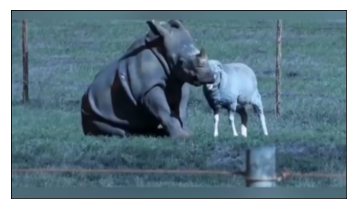

plow, plough (score = 0.07099)ox (score = 0.05986)Doberman, Doberman pinscher (score = 0.04926)


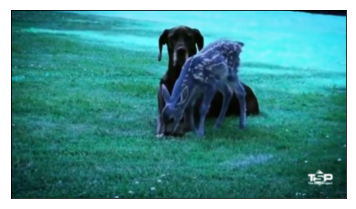

Weimaraner (score = 0.43624)German short-haired pointer (score = 0.26600)flat-coated retriever (score = 0.03602)


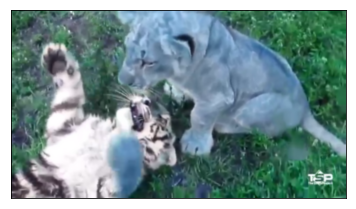

snow leopard, ounce, Panthera uncia (score = 0.21500)Arctic fox, white fox, Alopex lagopus (score = 0.13429)borzoi, Russian wolfhound (score = 0.06750)


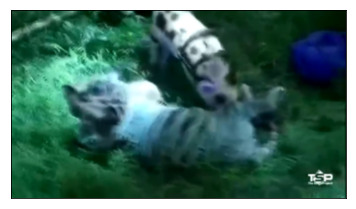

English setter (score = 0.08157)Sealyham terrier, Sealyham (score = 0.04162)wire-haired fox terrier (score = 0.03785)


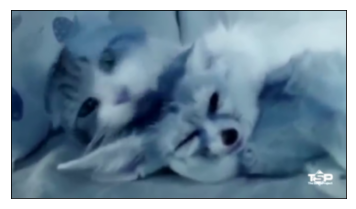

Arctic fox, white fox, Alopex lagopus (score = 0.18661)Samoyed, Samoyede (score = 0.04001)custard apple (score = 0.02808)


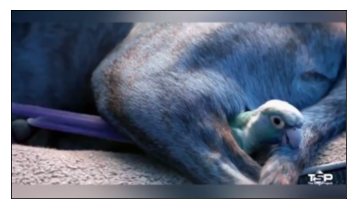

sea lion (score = 0.24207)hog, pig, grunter, squealer, Sus scrofa (score = 0.14623)wild boar, boar, Sus scrofa (score = 0.05837)


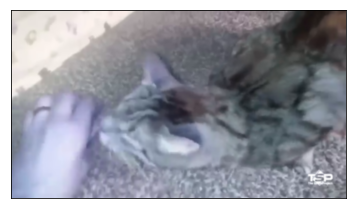

Egyptian cat (score = 0.77813)tabby, tabby cat (score = 0.02203)tiger cat (score = 0.01882)


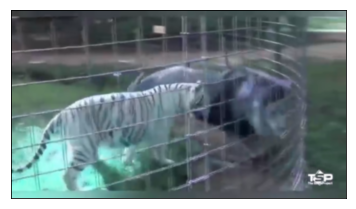

English setter (score = 0.42645)tiger, Panthera tigris (score = 0.09206)borzoi, Russian wolfhound (score = 0.04635)


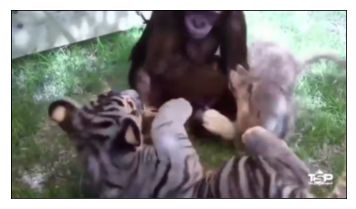

gyromitra (score = 0.11296)orangutan, orang, orangutang, Pongo pygmaeus (score = 0.04344)redbone (score = 0.03491)


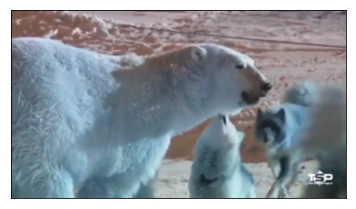

ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus (score = 0.96543)kuvasz (score = 0.00581)Great Pyrenees (score = 0.00278)


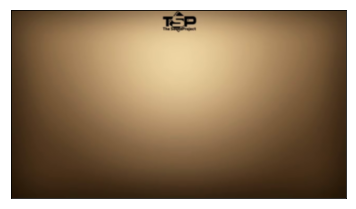

spotlight, spot (score = 0.48078)lampshade, lamp shade (score = 0.30750)table lamp (score = 0.06230)


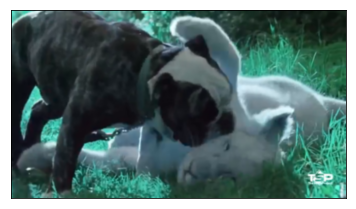

French bulldog (score = 0.66049)Boston bull, Boston terrier (score = 0.12784)American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (score = 0.04976)


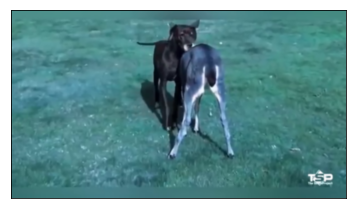

whippet (score = 0.78217)Italian greyhound (score = 0.13171)Great Dane (score = 0.04139)


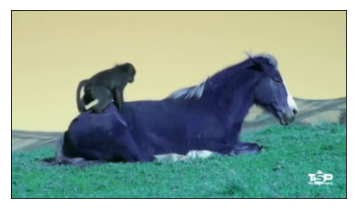

Saluki, gazelle hound (score = 0.15447)whippet (score = 0.09501)Great Dane (score = 0.04976)


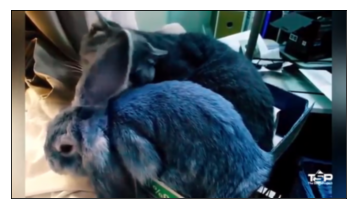

chimpanzee, chimp, Pan troglodytes (score = 0.11313)siamang, Hylobates syndactylus, Symphalangus syndactylus (score = 0.07154)gorilla, Gorilla gorilla (score = 0.05843)


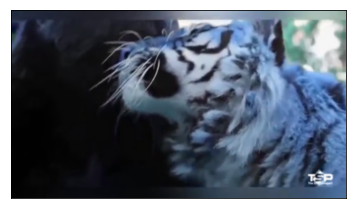

tiger, Panthera tigris (score = 0.61791)tiger cat (score = 0.11368)jaguar, panther, Panthera onca, Felis onca (score = 0.06796)


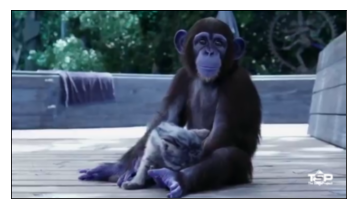

chimpanzee, chimp, Pan troglodytes (score = 0.58345)gorilla, Gorilla gorilla (score = 0.11294)orangutan, orang, orangutang, Pongo pygmaeus (score = 0.09678)


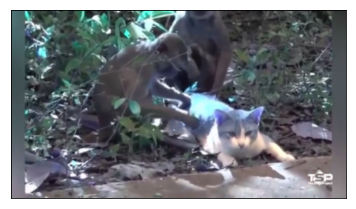

Italian greyhound (score = 0.09626)grey fox, gray fox, Urocyon cinereoargenteus (score = 0.09375)Weimaraner (score = 0.04594)


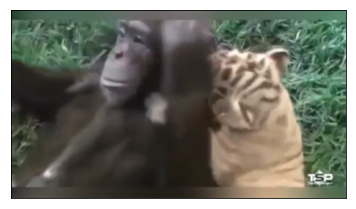

orangutan, orang, orangutang, Pongo pygmaeus (score = 0.27635)chimpanzee, chimp, Pan troglodytes (score = 0.17014)gyromitra (score = 0.07359)


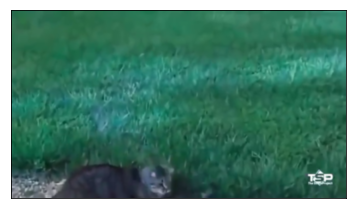

schipperke (score = 0.21189)groenendael (score = 0.10743)skunk, polecat, wood pussy (score = 0.09319)


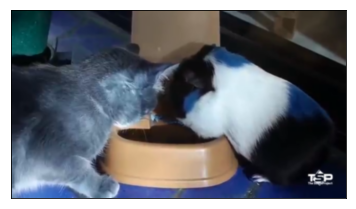

Angora, Angora rabbit (score = 0.20193)Sealyham terrier, Sealyham (score = 0.16883)miniature schnauzer (score = 0.12255)


In [15]:
predictions = recognize_object(frames)
for key in sorted(frames):
    plt.imshow(frames[key], cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(predictions[key])

# Prediction with Saved File

In [ ]:
frames = slice_video("videos/big_buck_bunny.mp4", True, "bunny")
print("extracted " + str(len(frames)) + " images")

predictions = recognize_object_from_file(frames.keys())
for key in sorted(frames):
    plt.imshow(frames[key], cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    print(predictions[key])

extracted 30 images
